In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split

sys.path.append("../utils")
from utils import load_data

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.neural_network import MLPRegressor
import shap
from pathlib import Path

/Users/lilameflah/anaconda3/envs/new_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the data 
data_train, data_test , targets= load_data(raw=False)
_,_, targets_train = load_data(raw=True)

In [4]:

project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' 
cgc_file = pd.read_csv(data_path / 'CGC.csv')

# Create the CGC array 
cgc_genes = cgc_file['Gene Symbol']

# Extract CGC genes
cgc_genes = np.array(cgc_genes)  # Convert to numpy array

In [6]:
# Filtring our dataset, deleting all the genes not present in the cgc_genes dataset
gene_train  = set(data_train.columns)
filtered_data_train = data_train.loc[:, data_train.columns.intersection(cgc_genes)]
print (filtered_data_train.shape)

(742, 735)


In [7]:
tissue_types = targets_train['tissue'].str.strip().unique()
print (tissue_types)

['Prostate' 'Esophagus/Stomach' 'Bladder/Urinary Tract' 'CNS/Brain'
 'Lymphoid' 'Kidney' 'Thyroid' 'Soft Tissue' 'Skin' 'Lung' 'Bone'
 'Ovary/Fallopian Tube' 'Pleura' 'Myeloid' 'Uterus' 'Pancreas' 'Breast'
 'Head and Neck' 'Bowel' 'Peripheral Nervous System' 'Cervix' 'Liver'
 'Biliary Tract' 'Other' 'Ampulla of Vater']


shap_values shape: (8, 735)


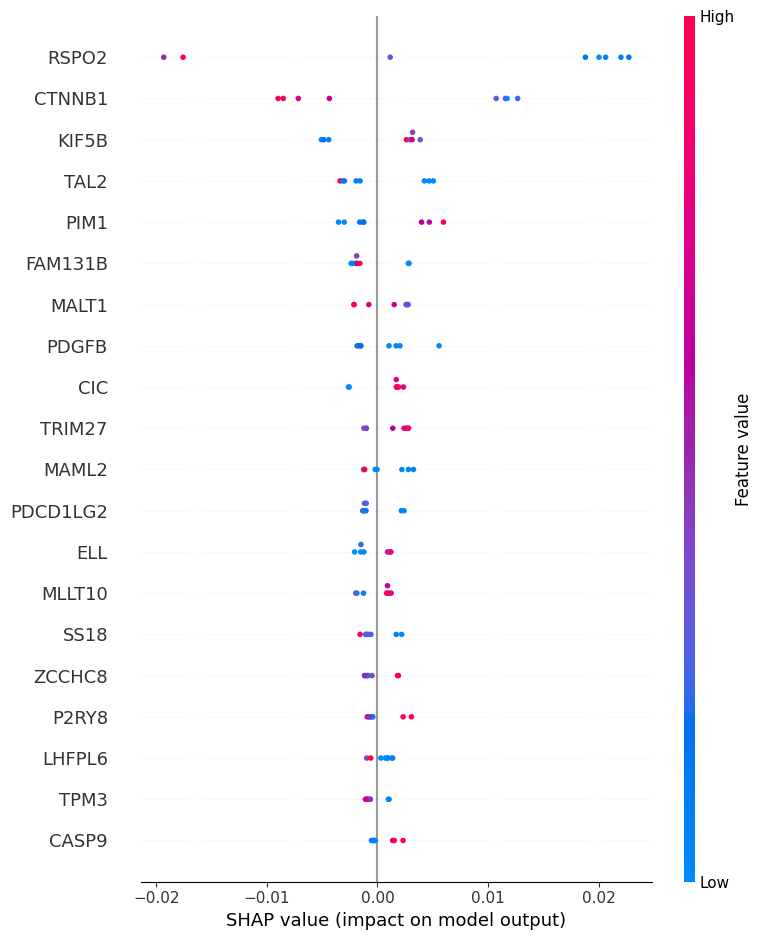

shap_values shape: (6, 735)


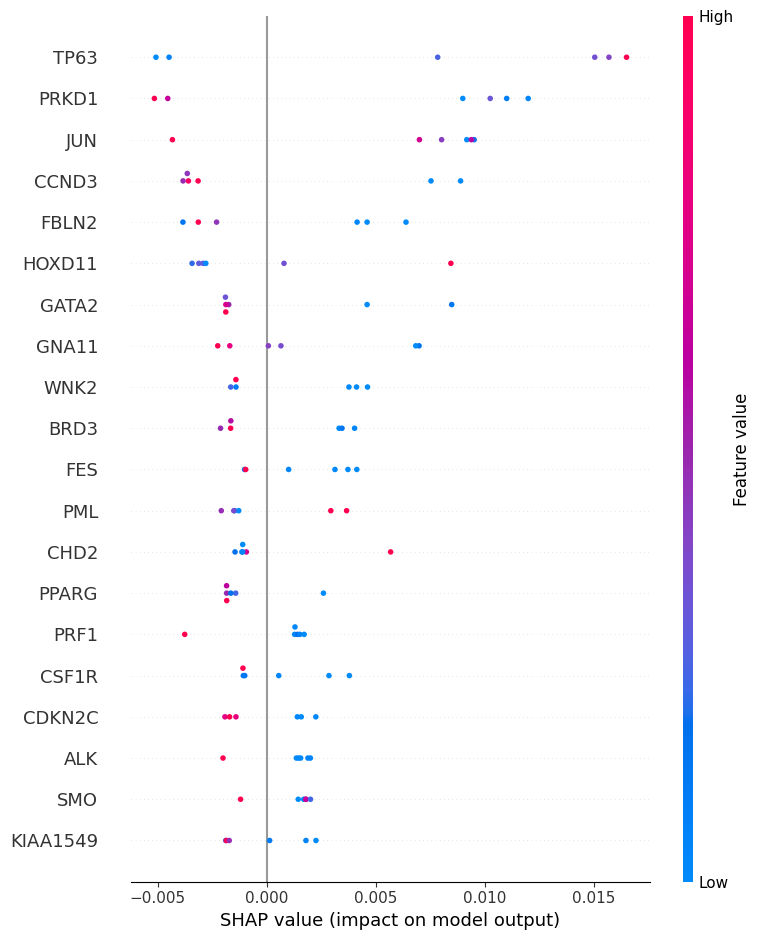

Skipping tissue 'Cervix' due to insufficient data (n=1).
                  Tissue  Number of Samples       MSE  Spearman's Correlation
0      Esophagus/Stomach                 54  0.005973                0.118182
1              CNS/Brain                 45  0.000992                0.400000
2               Lymphoid                 93  0.004180                0.514035
3                   Skin                 48  0.002027                0.272727
4                   Lung                128  0.011013                0.386391
5   Ovary/Fallopian Tube                 37  0.006338               -0.380952
6                Myeloid                 39  0.006406                0.738095
7               Pancreas                 36  0.004582               -0.476190
8                 Breast                 33  0.001850                0.678571
9          Head and Neck                 30  0.004953                0.714286
10                 Bowel                 39  0.007700                0.238095


In [8]:
# Placeholder for results
results = []

# Step 1: Extract unique tissue types from targets_train
tissue_types = targets_train['tissue'].str.strip().unique()

for tissue in tissue_types:

    # Filter rows in targets_train for the current tissue type
    filtred_target_tissue = targets_train[targets_train['tissue'].str.contains(tissue, case=False, na=False)]
    
    # Get the indices of these rows
    tissue_indices = filtred_target_tissue.index
    
    # Filter rows in train_target based on these indices
    filtered_train_tissue = filtered_data_train.iloc[tissue_indices]

    # Prepare feature matrix X and target vector Y
    X = filtered_train_tissue
    Y = filtred_target_tissue['AAC']
    
    # Number of samples for the tissue
    num_samples = len(X)
    
    # Check the size of the dataset
    if num_samples < 2:
        # Skip tissues with less than 2 samples
        print(f"Skipping tissue '{tissue}' due to insufficient data (n={num_samples}).")
        continue
    
    if num_samples >=30:
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
        
        # Train a Random Forest model
        random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
        random_forest.fit(X_train, y_train)
        
        # Predict on validation data
        y_val_pred = random_forest.predict(X_val)
        
        # Evaluate the model
        mse = mean_squared_error(y_val, y_val_pred)
        spearman_corr, p_value = spearmanr(y_val, y_val_pred)
            

        # Store the results for this tissue type
        results.append({
            'Tissue': tissue,
            'Number of Samples': num_samples,
            'MSE': mse,
            "Spearman's Correlation": spearman_corr
        })
    

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

print(results_df) 


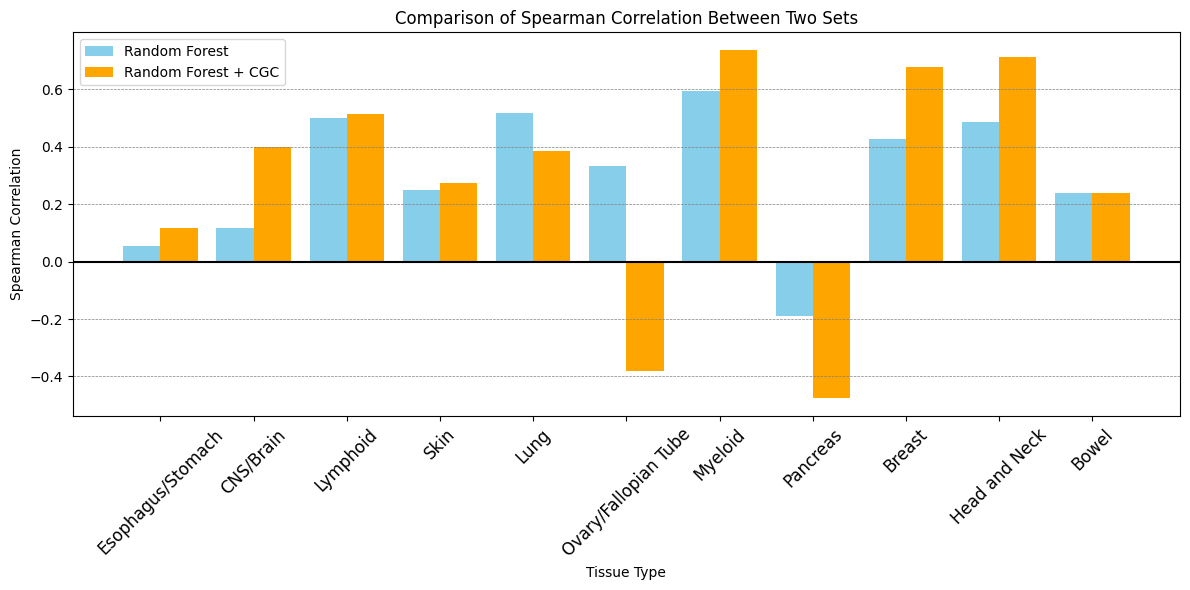

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Data extracted from the two images for comparison
tissues = [
    "Esophagus/Stomach", "CNS/Brain", "Lymphoid", "Skin", "Lung",
    "Ovary/Fallopian Tube", "Myeloid", "Pancreas", "Breast",
    "Head and Neck", "Bowel"
]

# Spearman's Correlation from second image
spearman = [
    0.054545, 0.116667, 0.500000, 0.248485, 0.518379,
    0.333333, 0.595238, -0.190476, 0.428571, 0.485714, 0.238095
]

# Spearman's Correlation from first image
spearman_CGC = [
    0.118182, 0.400000, 0.514035, 0.272727, 0.386391,
    -0.380952, 0.738095, -0.476190, 0.678571, 0.714286, 0.238095
]

# Create DataFrame for visualization
df = pd.DataFrame({
    "Tissue": tissues,
    "Spearman_Correlation_1": spearman,
    "Spearman_Correlation_2": spearman_CGC
})
# Plot comparison graph with a black horizontal line at 0.0 and a grid in the background
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
index = range(len(tissues))

# Plot bars for two Spearman Correlation sets
bar1 = plt.bar(index, df['Spearman_Correlation_1'], bar_width, color='skyblue', label='Random Forest')
bar2 = plt.bar([i + bar_width for i in index], df['Spearman_Correlation_2'], bar_width, color='orange', label='Random Forest + CGC')

# Add a horizontal line at 0.0
plt.axhline(0.0, color='black', linestyle='-', linewidth=1.5)

# Add a grid in the background
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# Labeling
plt.xlabel('Tissue Type')
plt.ylabel('Spearman Correlation')
plt.title('Comparison of Spearman Correlation Between Two Sets')
plt.xticks([i + bar_width / 2 for i in index], df['Tissue'], rotation=45,  fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()